## Dependencies ##

In [0]:
!pip install -U tensorboard
%load_ext tensorboard

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

# for n_iter in range(1000):
#     writer.add_scalar('Loss/train', np.random.random(), n_iter)
#     writer.add_scalar('Loss/test', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [0]:
# %tensorboard --logdir=runs

In [0]:
# imports 
import sys
import torch
import torchvision
from torch import nn
from datetime import datetime
from datetime import date
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim
from pathlib import Path
from torchvision import transforms
from torch.optim import lr_scheduler
import numpy as np 
from skimage import measure 
# import tifffile 
import time
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False
torch.__version__

'1.3.1'

In [0]:
classes = [torch.tensor(i) for i in range(21)]
classes.append(255)

In [0]:
def is_catagorical(mask):
  for x in torch.flatten(mask):
    if x not in classes:
      return False 
  return True 

In [0]:
# assert(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device.type == 'cuda':
  float_tensor = torch.cuda.FloatTensor
  long_tensor = torch.cuda.LongTensor
else:
  float_tensor = torch.FloatTensor
  long_tensor = torch.LongTensor

In [0]:
class PascalDataset(torchvision.datasets.voc.VOCSegmentation):
  def __init__(self,
              root,
              year='2012',
              image_set='train',
              download=False,
              transform=None,
              target_transform=None,
              transforms=None):
    # I don't pass the parent the transform so that I can control it for later 
    super(PascalDataset, self).__init__(root,
                                        year,
                                        image_set,
                                        download, 
                                        target_transform,
                                        transforms=None)   
    self._transform = transform
    self._target_transform = target_transform
    
  def __getitem__(self, index):
        # img, target = super(PascalDataset, self).__getitem__(idx)
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        if self._transform is not None:
          img = self._transform(img)
        if self._target_transform is not None:
          target = self._target_transform(target)

        return img, target 
        

In [0]:
class ImgToTensor(object):
    def __call__(self, pic):
        # the dataset already converts things to RGB
        return torch.from_numpy(pic)

class GtToTensor(object):

    def __call__(self, pic):
      # return torch.from_numpy(np.array(pic))
      return torch.from_numpy(np.array(pic, np.int64, copy=False))

In [0]:
# TODO: download data into gdrive
# just check if data is already downloaded
data_exists = not Path("data").exists()

# !mkdir original
original_transforms = transforms.Compose([transforms.ToTensor()])

train_transforms = transforms.Compose([
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.CenterCrop((112,246)),
    transforms.Resize((256,256)),  #add random crop? 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) # picked popular mean and std found online 
])

# it dosen't make sense to normalize the ground truth 
gt_transforms = transforms.Compose([
    # transforms.CenterCrop((112,246)),
    transforms.Resize((256,256)),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomHorizontalFlip(p=0.5),
    GtToTensor()
])
# pascal_original = PascalDataset('original/', year='2012', image_set='train', download= not Path("original").exists(), transform=[])
pascal_train_data = PascalDataset('data/', year='2012', image_set='train', download=data_exists, transform=train_transforms, target_transform=gt_transforms)
pascal_val_data = PascalDataset('data/', year='2012', image_set='val', download= data_exists, transform=train_transforms, target_transform=gt_transforms)

In [0]:
# img, label = pascal_original.__getitem__(0)

In [0]:
train_loader = torch.utils.data.DataLoader(pascal_train_data,
                                          batch_size=6,
                                          shuffle=True,
                                          num_workers=4)
val_Loader = torch.utils.data.DataLoader(pascal_val_data,
                                         batch_size=1,
                                         shuffle=False, 
                                         num_workers=4)
# original_loader = torch.utils.data.DataLoader(pascal_original,
#                                          batch_size=1,
#                                          shuffle=False, 
#                                          num_workers=4)

In [0]:
def train_model(model, criterion, optimizer, scheduler, data_loader = train_loader, num_epochs=25):
    since = time.time()
    model.train()
    best_acc = 0.0
    print("BEGIN TRAINING")
    writer = SummaryWriter('runs/unet_voc') 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        i = 0 

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loader:
          i += 1
          inputs = Variable(inputs, requires_grad = True).to(device) # 1 x 3 x 256 x 256
          labels = labels.type(float_tensor)
          # labels = Variable(labels, requires_grad = True).to(device) # 1 x 1 x 256 x 256 
          labels = labels.to(device)
          optimizer.zero_grad() # possible error. Should we zero out for the first iteration???
          outputs = model(inputs) # N x C x H x W  
          labels = labels.squeeze(1) # N x H x W
          labels = labels.type(long_tensor)
          # outputs = outputs.permute(2, 3, 1, 0).contiguous().view(256 * 256, 21)
          # labels = labels.permute(1, 2, 0).contiguous().view(256*256)
          # labels = labels * 255 #unnormalize the reference 
          # assert(is_catagorical(labels))
          loss = criterion(input=outputs, target=labels)
          loss.backward()
          optimizer.step()

          # statistics
          # running_loss += loss.item() * inputs.size(0)
          running_loss += loss.item()
          # running_corrects += torch.sum(outputs == labels.data)
      
          if i % 400 == 0:   
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1474,
                            epoch * len(data_loader.dataset) + i)
        if (epoch + 1) % 20 == 0:
          path = "int" + str(epoch) + ".pth"
          torch.save(model.state_dict(), path)
        scheduler.step()
        epoch_loss = (running_loss/6.0) / len(data_loader.dataset)
        print("epoch loss {}".format(epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [0]:
min_h = float("inf")
min_w = float("inf")
max_h = float("-inf") 
max_w = float("-inf")
small_count = 0 
big_count = 0 
avg_h = 0
avg_w = 0 
for img, gt in train_loader:
  "in iterator"
  print("img.shape: ", img.shape)
  print("gt.shape: ", gt.shape)
  _,_,h, w = img.shape
  assert((h,w) == (gt.shape[1],gt.shape[2]))
  if w < min_w:
    min_w = w 
  if h < min_h:
    min_h = h 
  if h > max_h:
    max_h = h
  if w >= max_w:
    max_w = w
  avg_h += h
  avg_w += w 
  break
print(min_h, min_w, small_count, big_count)
print(avg_h/len(train_loader.dataset), avg_w/len(train_loader.dataset))
print(len(train_loader.dataset))

img.shape:  torch.Size([6, 3, 256, 256])
gt.shape:  torch.Size([6, 256, 256])
256 256 0 0
0.17486338797814208 0.17486338797814208
1464


In [0]:
prebuilt_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=21, init_features=40, pretrained=False)
prebuilt_model.to(device)

In [0]:
def sample_data():
  for inputs, labels in train_loader:
    x , y = inputs, labels
    break
  return x, y

In [0]:
def sample_original():
  for inputs, labels in original_loader:
    x, y = inputs, labels
    break 
  return x,y

In [0]:
# inputs, labels = sample_data()
# print("LABELS", labels.dtype, labels.shape)
# inputs = Variable(inputs, requires_grad = True).to(device)
# labels = labels.type(torch.FloatTensor)
# labels = Variable(labels, requires_grad = True).to(device)

# print("inputs shape is {}".format(inputs.shape))
# print("labels shape is {}".format(labels.shape))
# outputs = prebuilt_model(inputs)
# print("preds shape", outputs.shape)
# # om = torch.argmax(outputs.squeeze(0), dim=0).detach().cpu().numpy()
# om = torch.argmax(outputs, dim=1).detach().cpu().numpy()
# print(om.shape)
# unorm = labels.detach().cpu().numpy().squeeze(0) * 255
# print(unorm.shape)
# plt.matshow(unorm * 255);
# plt.colorbar()
# plt.show()

In [0]:
# criterion = CrossEntropyLoss2d(size_average=False)
# F.binary_cross_entropy_with_logits
# nn.BCEWithLogitsLoss()
num_epochs = 80 
lr = 0.001
criterion = nn.CrossEntropyLoss(size_average=False,ignore_index=255)
# optimizer = optim.SGD(prebuilt_model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(params=prebuilt_model.parameters(), lr=lr)
# sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
sched = lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(train_loader) * num_epochs)) ** 0.9)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
# Start training
trained_model = train_model(model=prebuilt_model, criterion=criterion, optimizer=optimizer, scheduler=sched, num_epochs=num_epochs)

BEGIN TRAINING
Epoch 0/79
----------
epoch loss 26737.673603995903
Epoch 1/79
----------
epoch loss 24710.787397540982
Epoch 2/79
----------
epoch loss 24549.57517930328
Epoch 3/79
----------
epoch loss 24515.129546618853
Epoch 4/79
----------
epoch loss 24474.067267190345
Epoch 5/79
----------
epoch loss 24476.166310906192
Epoch 6/79
----------
epoch loss 24465.8095685337
Epoch 7/79
----------
epoch loss 24468.724819273677
Epoch 8/79
----------
epoch loss 24458.52774220173
Epoch 9/79
----------
epoch loss 24452.625334414846
Epoch 10/79
----------
epoch loss 24462.928705601094
Epoch 11/79
----------
epoch loss 24450.474584471765
Epoch 12/79
----------
epoch loss 24441.119556864753
Epoch 13/79
----------
epoch loss 24440.484239811023
Epoch 14/79
----------
epoch loss 24434.104501081514
Epoch 15/79
----------
epoch loss 24434.98851605191
Epoch 16/79
----------
epoch loss 24442.14051115665
Epoch 17/79
----------
epoch loss 24428.97772227914
Epoch 18/79
----------
epoch loss 24432.74302709

In [0]:
%tensorboard --logdir=runs

In [0]:
#save trained model in google drive 
from google.colab import drive
main_dir = '/content/drive/'
drive.mount(main_dir)
torch.save(trained_model.state_dict(),"drive/My Drive/Colab Notebooks/unet_addamlr.pth")
drive.flush_and_unmount()

In [0]:
#visualize results 
img, gt = sample_data()
img = Variable(img, requires_grad=True).cuda()
print("gt shape before being var: ", gt.shape)
gt = Variable(gt, requires_grad=True).cuda()
# assert(is_catagorical(gt * 255))
pred = trained_model(img)
pred = pred.squeeze(0)

logsoftmax = nn.LogSoftmax(dim=0)
# pred = logsoftmax(pred)
print(pred.shape)
pred = pred.argmax(dim = 0)
# assert(is_catagorical(pred))
unique = torch.unique(pred)
print('unique items: ', unique)
# img = img * 255
# print(type(img.detach().cpu().squeeze(0)))
# img = img.permute(2,3,1,0)
img = transforms.ToPILImage(mode='RGB')(img.detach().cpu().squeeze(0))
pred = transforms.ToPILImage()(np.float32(pred.detach().cpu()))

plt.imshow(img)
plt.show()

plt.imshow(pred)
plt.show()

# gt = gt.squeeze(0)
# gt = gt.detach().cpu().numpy()
# gt = transforms.ToPILImage()(gt * 255)
# plt.imshow(gt)
# plt.show()
print("Gt", gt.shape)
gt = transforms.ToPILImage()(gt * 255)
plt.imshow(gt)
plt.show()

print(np.sum(np.array(gt)))
plt.matshow(np.array(gt));
plt.colorbar()
plt.show()

In [0]:
def loss_fn(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses['out']

    return losses['out'] + 0.5

In [0]:
criterion = nn.functional.cross_entropy
test_pred = Variable(torch.ones(1,21,256,256), requires_grad=True).cuda()
test_gt = torch.ones(1,256,256)
test_gt = test_gt.type(torch.cuda.LongTensor)
unique = torch.unique(test_pred)
print(unique)
print(criterion(input=test_pred, target = test_gt, ignore_index=255))
criterion(test_pred.permute(2,3,0,1).contiguous().view(256*256, 21), test_gt.permute(1,2,0).contiguous().view(256*256))

In [0]:
img, gt = sample_data()
img = Variable(img, requires_grad = True).cuda()
pred = prebuilt_model(img) # 1 x 20 x H x W
pred = pred.squeeze(0)
print(torch.sum(pred))
pred = softmax(pred)
print(torch.sum(pred))
# print(torch.sum(logsoftmax(pred)))
pred = pred.argmax(dim=0)
pred = pred.detach().cpu().numpy()
print(np.sum(pred))
# rgb = decode_segmap(pred)
# plt.imshow(rgb); plt.show()
# print(type(pred))
pred_img = transforms.ToPILImage()(np.float32(pred))
print(pred.shape)
print(type(pred))
plt.imshow(pred_img)
plt.show()

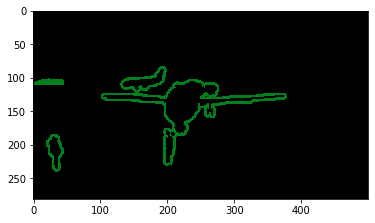

In [0]:
np.set_printoptions(threshold=sys.maxsize)
softmax = nn.Softmax(dim=0)

img, gt = sample_original()
# img = Variable(img, requires_grad = True).cuda()
gt = Variable(gt, requires_grad=True).cuda()
# pred = prebuilt_model(img) # 1 x 20 x H x W
# pred = pred.squeeze(0)
# print(torch.sum(pred))
# pred = softmax(pred)
# print(torch.sum(pred))
# print(torch.sum(logsoftmax(pred)))
# pred = pred.argmax(dim=0)
# pred_detached = pred.detach().byte().cpu().numpy()
# output_predictions.byte().cpu().numpy()

gt = gt.squeeze(0).squeeze(0)
gt_detached = gt.detach().byte().cpu().numpy()
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(gt_detached)
r.putpalette(colors)

plt.imshow(r)
plt.show()

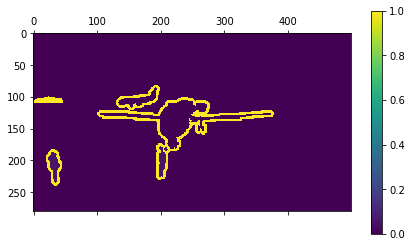

In [0]:
plt.matshow(gt.detach().cpu().numpy());
plt.colorbar()
plt.show()

In [0]:
#https://github.com/tensorflow/models/blob/a76bc1256ffd04bdccb73442986858a0675c9c31/research/deeplab/utils/get_dataset_colormap.py#L317
_ADE20K = 'ade20k'
_CITYSCAPES = 'cityscapes'
_MAPILLARY_VISTAS = 'mapillary_vistas'
_PASCAL = 'pascal'

_DATASET_MAX_ENTRIES = {
    _ADE20K: 151,
    _CITYSCAPES: 256,
    _MAPILLARY_VISTAS: 66,
    _PASCAL: 512,
}
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((_DATASET_MAX_ENTRIES[_PASCAL], 3), dtype=int)
  ind = np.arange(_DATASET_MAX_ENTRIES[_PASCAL], dtype=int)

  for shift in reversed(list(range(8))):
    for channel in range(3):
      colormap[:, channel] |= bit_get(ind, channel) << shift
    ind >>= 3

  return colormap

def bit_get(val, idx):
  """Gets the bit value.
  Args:
    val: Input value, int or numpy int array.
    idx: Which bit of the input val.
  Returns:
    The "idx"-th bit of input val.
  """
  return (val >> idx) & 1

def label_to_color_image(label, dataset=_PASCAL):
  """Adds color defined by the dataset colormap to the label.
  Args:
    label: A 2D array with integer type, storing the segmentation label.
    dataset: The colormap used in the dataset.
  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the dataset color map.
  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label. Got {}'.format(label.shape))

  if np.max(label) >= _DATASET_MAX_ENTRIES[dataset]:
    raise ValueError(
        'label value too large: {} >= {}.'.format(
            np.max(label), _DATASET_MAX_ENTRIES[dataset]))

  colormap = create_pascal_label_colormap()
  return colormap[label]

In [0]:
# print(type(gt.detach().cpu().numpy()))
# label_to_color_image(label = gt.detach().cpu().numpy().astype(int))

P


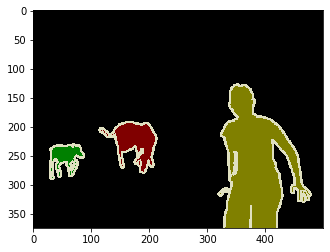

sum:  2124018


In [0]:
gt = Image.open('data/VOCdevkit/VOC2012/SegmentationObject/2011_000069.png')
print(gt.mode)
plt.imshow(gt)
plt.show()
print("sum: ", np.sum(np.array(gt)))

before tensor shape:  (500, 375)
shpe:  torch.Size([1, 375, 500])
mean:  tensor(0.0444)
sum of gt_tensor tensor(8329.4941)
tensor(2124018.)
test shape:  (1, 375, 500)
tensor(8329.4824, device='cuda:0', grad_fn=<SumBackward0>)


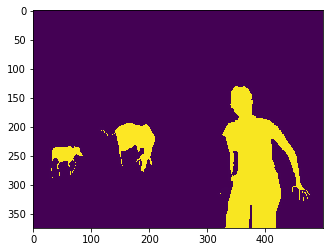

5680910


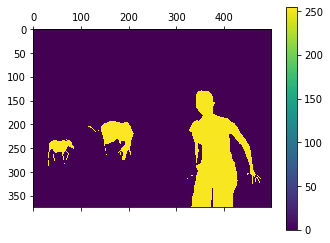

In [0]:
print("before tensor shape: ", gt.size)
gt_tensor = transforms.ToTensor()(gt)
print("shpe: ", gt_tensor.shape)
print("mean: ", torch.mean(gt_tensor))
print("sum of gt_tensor", torch.sum(gt_tensor))
print(torch.sum(gt_tensor * 255))
test = gt_tensor * 255 
test = test.detach().byte().cpu().numpy()
print("test shape: ", test.shape)
test = test.squeeze(0)
# print(test)
# assert(is_catagorical(test))
print(torch.sum(Variable(gt_tensor, requires_grad = True).to(device)))
gt_img = transforms.ToPILImage(mode="L")(gt_tensor * 255)
plt.imshow(gt_img)
plt.show()

print(np.sum(np.array(gt_img)))
plt.matshow(np.array(gt_img));
plt.colorbar()
plt.show()

shape:  torch.Size([1, 375, 500])
sum of gt_var:  tensor(8329.4824, device='cuda:0', grad_fn=<SumBackward0>)
shape of detached:  (375, 500)
sum of detached:  8095


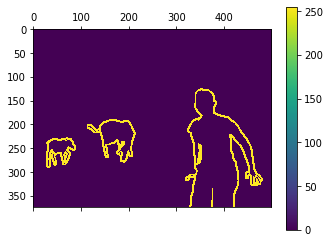

8329.482

In [0]:
gt_var = Variable(gt_tensor, requires_grad=True).cuda()
print("shape: ", gt_var.shape)
print("sum of gt_var: ", torch.sum(gt_var))
gt_detached = gt_var.detach().byte().cpu().numpy()
print("shape of detached: ", gt_detached.squeeze(0).shape)
print("sum of detached: ", np.sum(gt_detached))
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(gt_tensor.numpy().squeeze(0))
# r.putpalette(colors)
# plt.imshow(r)
# plt.show()


# plt.matshow(gt_tensor.numpy().squeeze(0) * 255);
plt.matshow(gt_detached.squeeze(0) * 255)
plt.colorbar()
plt.show()
np.sum(gt_tensor.numpy().squeeze(0))

In [0]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()

# 2D loss example (used, for example, with image inputs)
N, C = 5, 4
# input is of size N x C x height x width
data = torch.randn(N, 16, 10, 10)
conv = nn.Conv2d(16, C, (3, 3))
# each element in target has to have 0 <= value < C
target = torch.empty(N, 8, 8, dtype=torch.long).random_(0, C)
print("target", target.shape)
print("input", m(conv(data)).shape)
output = loss(m(conv(data)), target)
output.backward()

target torch.Size([5, 8, 8])
input torch.Size([5, 4, 8, 8])


## Create UNet ##

In [0]:
# helper operations 
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x 
        
def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        self.layer1 = conv3x3(in_channels, out_channels)
        self.layer2 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()
        self.contract = maxpool2x2()
        self.layer1 = conv3x3(in_channels, out_channels)
        self.layer2 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = self.contract(x)
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()
        self.expand = UpConv2x2(in_channels)
        self.layer1 = conv3x3(in_channels, out_channels)
        self.layer2 = conv3x3(out_channels, out_channels)



    def forward(self, xh, xv):
        """
        Args:
            xh: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xv: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        xv = self.expand.forward(xv)
        x = concat(xh, xv)
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])

        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        
        # self.conv_out = conv3x3(fs[0], 1)
        self.conv_out = conv3x3(fs[0], 20)

        self._initialize_weights()

    def forward(self, x):
        x = self.conv_in(x)
        
        sub_1 = self.dconv1(x)
        sub_2 = self.dconv2(sub_1)
        sub_3 = self.dconv3(sub_2)
        sub_4 = self.dconv4(sub_3)
        
        base_1 = self.uconv1(sub_3, sub_4)
        base_2 = self.uconv2(sub_2, base_1)
        base_3 = self.uconv3(sub_1, base_2)
        x = self.uconv4(x, base_3)
        
        
        x = self.conv_out(x)
        return x

    def _initialize_weights(self):
        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]
        for m in conv_modules:
            n = 2/(m.kernel_size[0] * m.kernel_size[1] * m.out_channels)
            m.weight.data.normal_(0.0, np.sqrt(n))


## Train UNet ##

In [0]:
data_exists = not Path("data").exists()

train_transforms = transforms.Compose([
    # transforms.CenterCrop((112,246)),
    transforms.Resize((512,512)),
    transforms.Grayscale(1),
    transforms.ToTensor(),  # Didn't normalize because image has been converted here to grayscale 
])

# it dosen't make sense to normalize the ground truth 
test_transforms = transforms.Compose([
    # transforms.CenterCrop((112,246)),
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

pascal_train_data = torchvision.datasets.VOCSegmentation('data/', year='2012', image_set='train', download=data_exists, transform=train_transforms, target_transform=test_transforms)
pascal_val_data = torchvision.datasets.VOCSegmentation('data/', year='2012', image_set='val', download= data_exists, transform=train_transforms, target_transform=test_transforms)

In [0]:
train_loader = torch.utils.data.DataLoader(pascal_train_data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=4)
val_Loader = torch.utils.data.DataLoader(pascal_val_data,
                                         batch_size=1,
                                         shuffle=False, 
                                         num_workers=4)

In [0]:
def sample_data():
  for inputs, labels in train_loader:
    x , y = inputs, labels
    break
  return x, y

In [0]:
def sample_val():
  for inputs, labels in val_Loader:
    x , y = inputs, labels
    break
  return x, y

In [0]:
# train utils
def np2var(arr, cuda):
    arr = np.expand_dims(np.expand_dims(arr, 0), 0)
    arr = torch.from_numpy(arr)
    arr = Variable(arr)
    if cuda:
        arr = arr.cuda()
    return arr

def var2np(arr):
    arr = arr.data.cpu().numpy()[0,0]
    return arr
    

In [0]:
# plot utils
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

def plot(step, log_every, train_loss, val_loss, img_trn, img_val, pred_trn, pred_val, true_trn, true_val):
    clear_output(wait=False)
    plt.gcf().clear()
    
    plt.subplot(241)
    iters = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")

    plt.subplot(242)
    plt.imshow(img_trn, cmap='gray')
    plt.title("Input image, train")
    
    plt.subplot(243)
    plt.imshow(pred_trn, cmap='gray')
    plt.title("Predicted, train")
    
    
    plt.subplot(244)
    plt.imshow(true_trn, cmap='gray')
    plt.title("True, train")
    
    plt.subplot(246)
    plt.imshow(img_val, cmap='gray')
    plt.title("Input image, val")
    
    plt.subplot(247)
    plt.imshow(pred_val, cmap='gray')
    plt.title("Predicted, val")
    
    
    plt.subplot(248)
    plt.imshow(true_val, cmap='gray')
    plt.title("True, val")


    plt.gcf().set_size_inches(18, 7)
    display(plt.gcf())

In [0]:
len(train_loader.dataset)

1464

In [0]:
# params
USECUDA = True
max_iter = 2000
log_every = 5
plot_every = 100
lr = 0.001
num_epochs = 10
# create net
net = UNet()
if USECUDA:
    net.cuda()
    
# create optimizer 
optimizer = optim.Adam(net.parameters(), lr=lr)
net

In [0]:
## Train network ##
net.train()
# train net
losses_trn = []
losses_val = []
softmax = nn.Softmax(dim=1)
crit = nn.CrossEntropyLoss()
logsoftmax = nn.LogSoftmax(1)

print("BEGIN TRAINING")
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  
  running_loss = 0.0
  # Iterate over data.
  for img, bdy in train_loader:

    img = Variable(img, requires_grad = True).cuda()
    bdy = Variable(bdy, requires_grad = True).cuda()
    # forward, backward, update
    optimizer.zero_grad() #TODO: Don't call zero grad on t == 0? 
    pred = net(img)           
    bdy = bdy.squeeze(1)
    # pred = logsoftmax(pred)
    bdy = bdy.type(torch.cuda.LongTensor)
    pred = pred.permute(2, 3, 1, 0).contiguous().view(512 * 512, 20)
    bdy = bdy.permute(1, 2, 0).contiguous().view(512*512)
    loss = crit(input=pred, target=bdy)
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
  
  print("Avg Loss: {}".format(running_loss/len(train_loader.dataset)))

  # log stuff
  # if t % log_every == 0: 
  #     net.eval()
  #     # validation info
  #     img_val, bdy_val = sample_val()
  #     # format
  #     # img_val = np2var(img_val, cuda=USECUDA)
  #     # bdy_val = np2var(bdy_val, cuda=USECUDA)
  #     img_val = Variable(img_val, requires_grad = True).cuda()
  #     bdy_val = Variable(bdy_val, requires_grad = True).cuda()

  #     # forward
  #     pred_val = net(img_val)           
  #     bdy_val = bdy_val.squeeze(1)
  #     pred_val = logsoftmax(pred_val)
  #     bdy_val = bdy_val.type(torch.cuda.LongTensor)
  #     pred_val = pred_val.permute(2, 3, 1, 0).contiguous().view(512 * 512, 20)
  #     bdy_val = bdy_val.permute(1, 2, 0).contiguous().view(512*512)
  #     loss_val = crit(input=pred_val, target=bdy_val)

  #     # store
  #     losses_trn.append(loss.item())
  #     losses_val.append(loss_val.item())
      # net.train()
  # plot stuff
  # if t % plot_every == 0:
  #     print("img", img.shape)
  #     print("img_val", img_val.shape)
  #     # plot(t, log_every, losses_trn, losses_val, 
  #     #       var2np(img), var2np(img_val),
  #     #       var2np(F.sigmoid(pred)), var2np(F.sigmoid(pred_val)),
  #     #       var2np(bdy), var2np(bdy_val))
  #     print("training loss: ", loss)
  #     print(loss_val)

BEGIN TRAINING
Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Avg Loss: 0.2547574838562334
Epoch 1/9
----------
Avg Loss: 0.21521833990166178
Epoch 2/9
----------
Avg Loss: 0.21478948031190803
Epoch 3/9
----------
Avg Loss: 0.2147045048243809
Epoch 4/9
----------
Avg Loss: 0.21429853246399694
Epoch 5/9
----------
Avg Loss: 0.21435658205453245
Epoch 6/9
----------
Avg Loss: 0.21446060045505239
Epoch 7/9
----------
Avg Loss: 0.21408507077511948
Epoch 8/9
----------
Avg Loss: 0.21409189336694004
Epoch 9/9
----------
Avg Loss: 0.21450357948546933


In [0]:
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
def decode_segmap(image, nc=21):
   
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

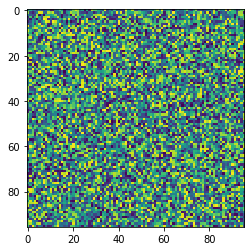

In [0]:
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))
plt.imshow(image)

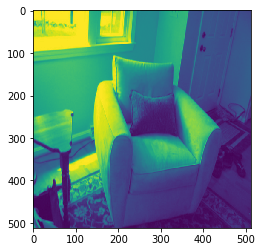

In [0]:
img, target = sample_data()
img_2d = img.squeeze(0).squeeze(0)
image = transforms.ToPILImage()(img_2d)
plt.imshow(image)

tensor(-61002704., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10239.9961, device='cuda:0', grad_fn=<SumBackward0>)
271880
(512, 512)
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


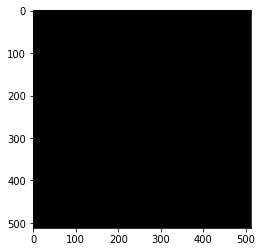

In [0]:
img = Variable(img, requires_grad = True).cuda()
pred = net(img) # 1 x 20 x H x W
pred = pred.squeeze(0)
print(torch.sum(pred))
pred = softmax(pred)
print(torch.sum(pred))
# print(torch.sum(logsoftmax(pred)))
pred = pred.argmax(dim=0)
pred = pred.detach().cpu().numpy()
print(np.sum(pred))
# rgb = decode_segmap(pred)
# plt.imshow(rgb); plt.show()
# print(type(pred))
pred_img = transforms.ToPILImage()(np.float32(pred))
print(pred.shape)
print(type(pred))
plt.imshow(pred_img)
plt.show()

## Make Segmentations ##

In [0]:
# inspect outputs
def plot_boundaries(im1, im2, im3):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(im1, cmap='gray')
    plt.subplot(132)
    plt.imshow(im2, cmap='gray')
    plt.subplot(133)
    plt.imshow(im3, cmap='gray')
    plt.show()
    

# training set 
img = imgs_trn[5]
true = bdys_trn[5]
pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA))))
plot_boundaries(img, true, pred)

# validation set
img = imgs_val[5]
true = bdys_val[5]
pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA))))
plot_boundaries(img, true, pred)

NameError: ignored

In [0]:
# analyze results
def plot_segmentations(im1, im2, im3):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(im1, cmap='gray')
    plt.subplot(132)
    plt.imshow(im2, cmap='nipy_spectral')
    plt.subplot(133)
    plt.imshow(im3, cmap='nipy_spectral')
    plt.show()
    
# training 
z = 5
img = imgs_trn[z]
bdy_true = bdys_trn[z]
bdy_pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA)))) > 0.5
seg_true = randomize_ids(segs_trn[z])
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(img, seg_true, seg_pred)

# validation 
z = 5
img = imgs_val[z]
bdy_true = bdys_val[z]
bdy_pred = var2np(F.sigmoid(net(np2var(img, cuda=USECUDA)))) > 0.5
seg_true = randomize_ids(segs_val[z])
seg_pred = randomize_ids(connected_components(np.expand_dims(bdy_pred, 0))[0])
plot_segmentations(img, seg_true, seg_pred)

## Receptive Field ##

In [0]:
def input_gradient(img, net, y, x):
    """Compute the gradient of the output pixel (y,x) with respect to the input image
    Args:
        img: torch Variable, input image
        net: torch network, randomly initialized weights
        y, x: ints, location of pixel for which to compute gradient
        
    Output:
        grad: float 32 numpy array, gradient of pixel with respect to input image 
                grad.shape = (img.shape[2], img.shape[3])
    """
    ## Your code here ##
    pred = net.forward(img)
    pred.retain_grad()
    pixel = pred[0,0,x,y]
    pixel.backward()
    return img.grad.data[0,0,:,:].numpy()
  
  
  
random_net = UNet()
img = Variable(torch.from_numpy(np.expand_dims(np.expand_dims(imgs_trn[0], 0), 0)), requires_grad=True)
grad = input_gradient(img, random_net, 256, 256)
nonzero = (grad != 0.0)


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(nonzero, cmap='gray')

im = np.copy(imgs_trn[0])
im[~nonzero] = 0.0
plt.subplot(122)
plt.imshow(im, cmap='gray')
plt.show()

print(np.sqrt(np.count_nonzero(nonzero == 1)))

Generally the analytic calculation which comes out to roughly 185 acts like a lower bound on the receptive field size. Intuitively, The positive gradient values approximate the receptive field size as the portions of the image that the feature is "searching" for will have greater values. 